<a href="https://colab.research.google.com/github/Chantm7777/NBA-Win-Loss-Prediction/blob/main/NBA_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [771]:
pip install gspread gspread_dataframe ta arch keras-tuner

In [772]:
pip install xlrd==1.2.0

In [885]:



from google.colab import drive
drive.mount('/content/drive')

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import pandas as pd
import yfinance as yf
import ta
from datetime import datetime
import numpy as np
from arch import arch_model
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import shutil
shutil.rmtree('tuner_dir', ignore_errors=True)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
from concurrent.futures import ThreadPoolExecutor, as_completed
from queue import Queue
from tqdm import tqdm  # For the progress bar
import pandas as pd
from datetime import datetime
import threading
import seaborn as sns
from collections import Counter
import keras_tuner as kt
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm
from tqdm import tqdm  # For progress bars
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import requests
from bs4 import BeautifulSoup
import pandas as pd
from urllib.parse import parse_qs, urlparse
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import numpy as np
import gspread
from gspread_dataframe import get_as_dataframe
from google.colab import auth
from google.auth import default
from gspread_dataframe import get_as_dataframe, set_with_dataframe
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Hnadling Data

In [774]:
# Path to your Excel files
folder_path = '/content/drive/MyDrive/DEN'

In [775]:
# Get all Excel files in the folder
excel_files = [f for f in os.listdir(folder_path) if f.endswith('.xls') or f.endswith('.xlsx')]
print(f"Found {len(excel_files)} Excel files")

Found 11 Excel files


In [776]:
# List to store dataframes
all_dfs = []

In [777]:
# Process each file
for file_name in excel_files:
    file_path = os.path.join(folder_path, file_name)
    print(f"Processing: {file_name}")

    # Read file and skip first row
    df = pd.read_excel(file_path, skiprows=1)
    all_dfs.append(df)

Processing: 1415.xlsx
Processing: 1516.xlsx
Processing: 1617.xlsx
Processing: 1718.xlsx
Processing: 1819.xlsx
Processing: 1920.xlsx
Processing: 2021.xlsx
Processing: 2122.xlsx
Processing: 2223.xlsx
Processing: 2324.xlsx
Processing: 2425.xlsx


In [778]:
# Concatenate all dataframes
combined_df = pd.concat(all_dfs, ignore_index=True)
print(f"Combined DataFrame shape: {combined_df.shape}")


Combined DataFrame shape: (883, 28)


In [779]:
combined_df.head()

,Rk,Gtm,Date,Unnamed: 3,Opp,Rslt,Tm,Opp.1,OT,ORtg,...,BLK%,eFG%,TOV%,ORB%,FT/FGA,eFG%.1,TOV%.1,ORB%.1,FT/FGA.1,ORtg▼
0,1,1,2014-10-29,NaN,DET,W,89,79,NaN,91.9,...,6.9,0.388,13.2,27.5,0.271,0.405,14.8,17.8,0.131,NaN
1,2,2,2014-11-01,@,OKC,L,91,102,NaN,94.2,...,16.7,0.481,16.9,23.9,0.175,0.500,13.0,16.7,0.275,NaN
2,3,3,2014-11-03,NaN,SAC,L,105,110,NaN,103.0,...,9.7,0.414,12.2,29.4,0.301,0.432,15.0,34.1,0.494,NaN
3,4,4,2014-11-05,@,SAC,L,109,131,NaN,109.6,...,8.9,0.506,12.8,18.4,0.317,0.605,11.7,26.5,0.513,NaN
4,5,5,2014-11-07,NaN,CLE,L,101,110,NaN,103.9,...,8.2,0.535,12.4,18.2,0.118,0.512,8.4,15.0,0.286,NaN


In [780]:
combined_df.columns

Index(['Rk', 'Gtm', 'Date', 'Unnamed: 3', 'Opp', 'Rslt', 'Tm', 'Opp.1', 'OT',
       'ORtg', 'DRtg', 'Pace', 'FTr', '3PAr', 'TS%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'eFG%', 'TOV%', 'ORB%', 'FT/FGA', 'eFG%.1', 'TOV%.1', 'ORB%.1',
       'FT/FGA.1', 'ORtg▼'],
      dtype='object')

In [781]:
den = combined_df.copy()

In [782]:
den['p_diff'] = den['Tm']-den['Opp.1']

In [783]:
den = den.sort_values('Date')

In [784]:
den['Rest_Days'] = den['Date'].diff().dt.days

In [785]:
den['Rest_Days'] = den['Rest_Days'].fillna(3).astype(int)

In [786]:
den['Target'] = den['Rslt'].apply(lambda x: 1 if x == 'W' else 0)
den['OT'] = den['Unnamed: 3'].apply(lambda x: 1 if x == '@' else 0)

In [787]:
den.columns

Index(['Rk', 'Gtm', 'Date', 'Unnamed: 3', 'Opp', 'Rslt', 'Tm', 'Opp.1', 'OT',
       'ORtg', 'DRtg', 'Pace', 'FTr', '3PAr', 'TS%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'eFG%', 'TOV%', 'ORB%', 'FT/FGA', 'eFG%.1', 'TOV%.1', 'ORB%.1',
       'FT/FGA.1', 'ORtg▼', 'p_diff', 'Rest_Days', 'Target'],
      dtype='object')

In [788]:
den['ORtg▼']

,ORtg▼
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
878,NaN
879,NaN
880,NaN
881,NaN


In [789]:
den['Rest_Days']

,Rest_Days
0,3
1,3
2,2
3,2
4,2
...,...
878,2
879,2
880,3
881,2


## Check the Corr and dist.

In [790]:
cols = ['Tm', 'Opp.1','OT',
       'ORtg', 'DRtg', 'Pace', 'FTr', '3PAr', 'TS%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'eFG%', 'TOV%', 'ORB%', 'FT/FGA', 'eFG%.1', 'TOV%.1', 'ORB%.1',
       'FT/FGA.1','p_diff', 'Rest_Days', 'Target']

In [791]:
# Create a correlation matrix
corr = den[cols].corr()

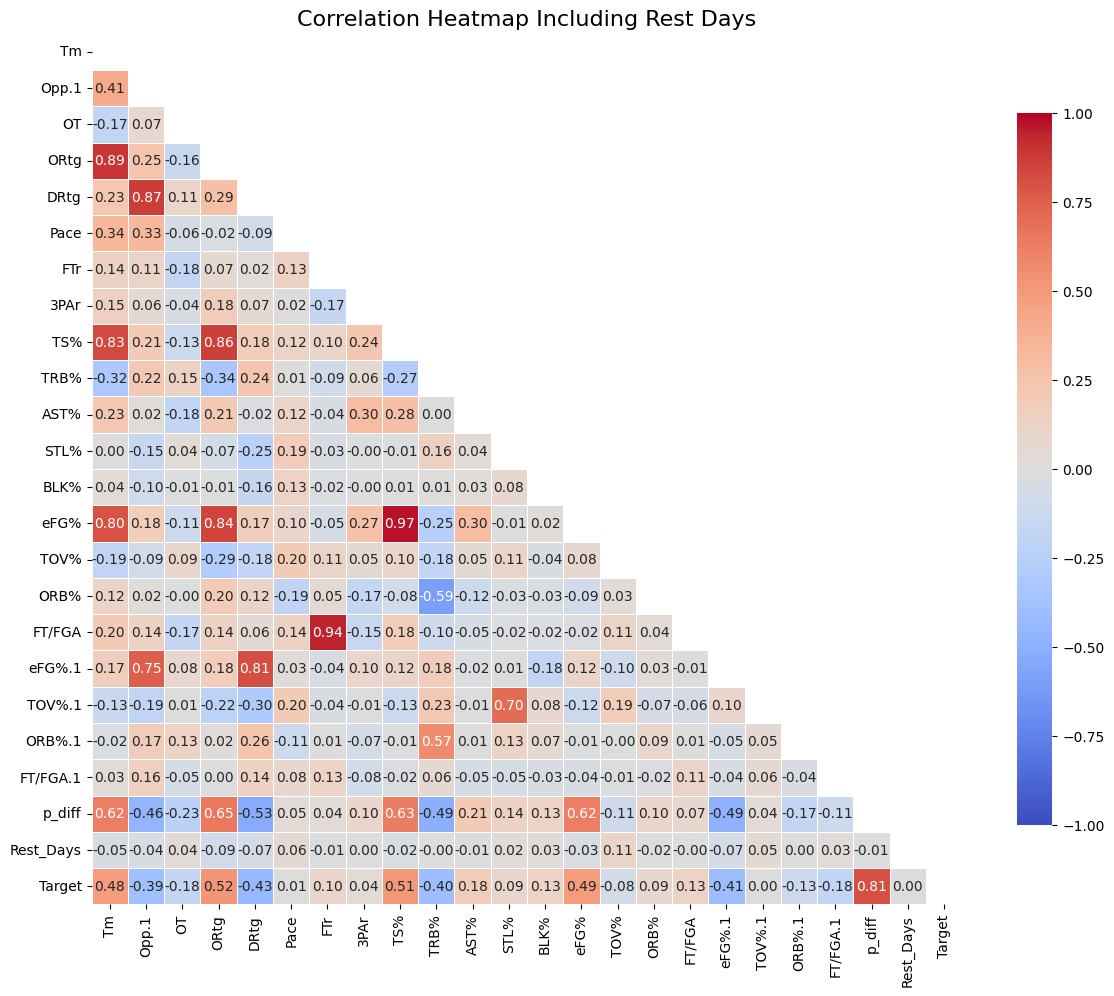

In [792]:
# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with a color bar
mask = np.triu(np.ones_like(corr, dtype=bool))  # For triangular heatmap
heatmap = sns.heatmap(corr, annot=True, mask=mask, cmap='coolwarm', vmin=-1, vmax=1,
                     square=True, linewidths=.5, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap Including Rest Days', fontsize=16)
plt.tight_layout()
plt.show()

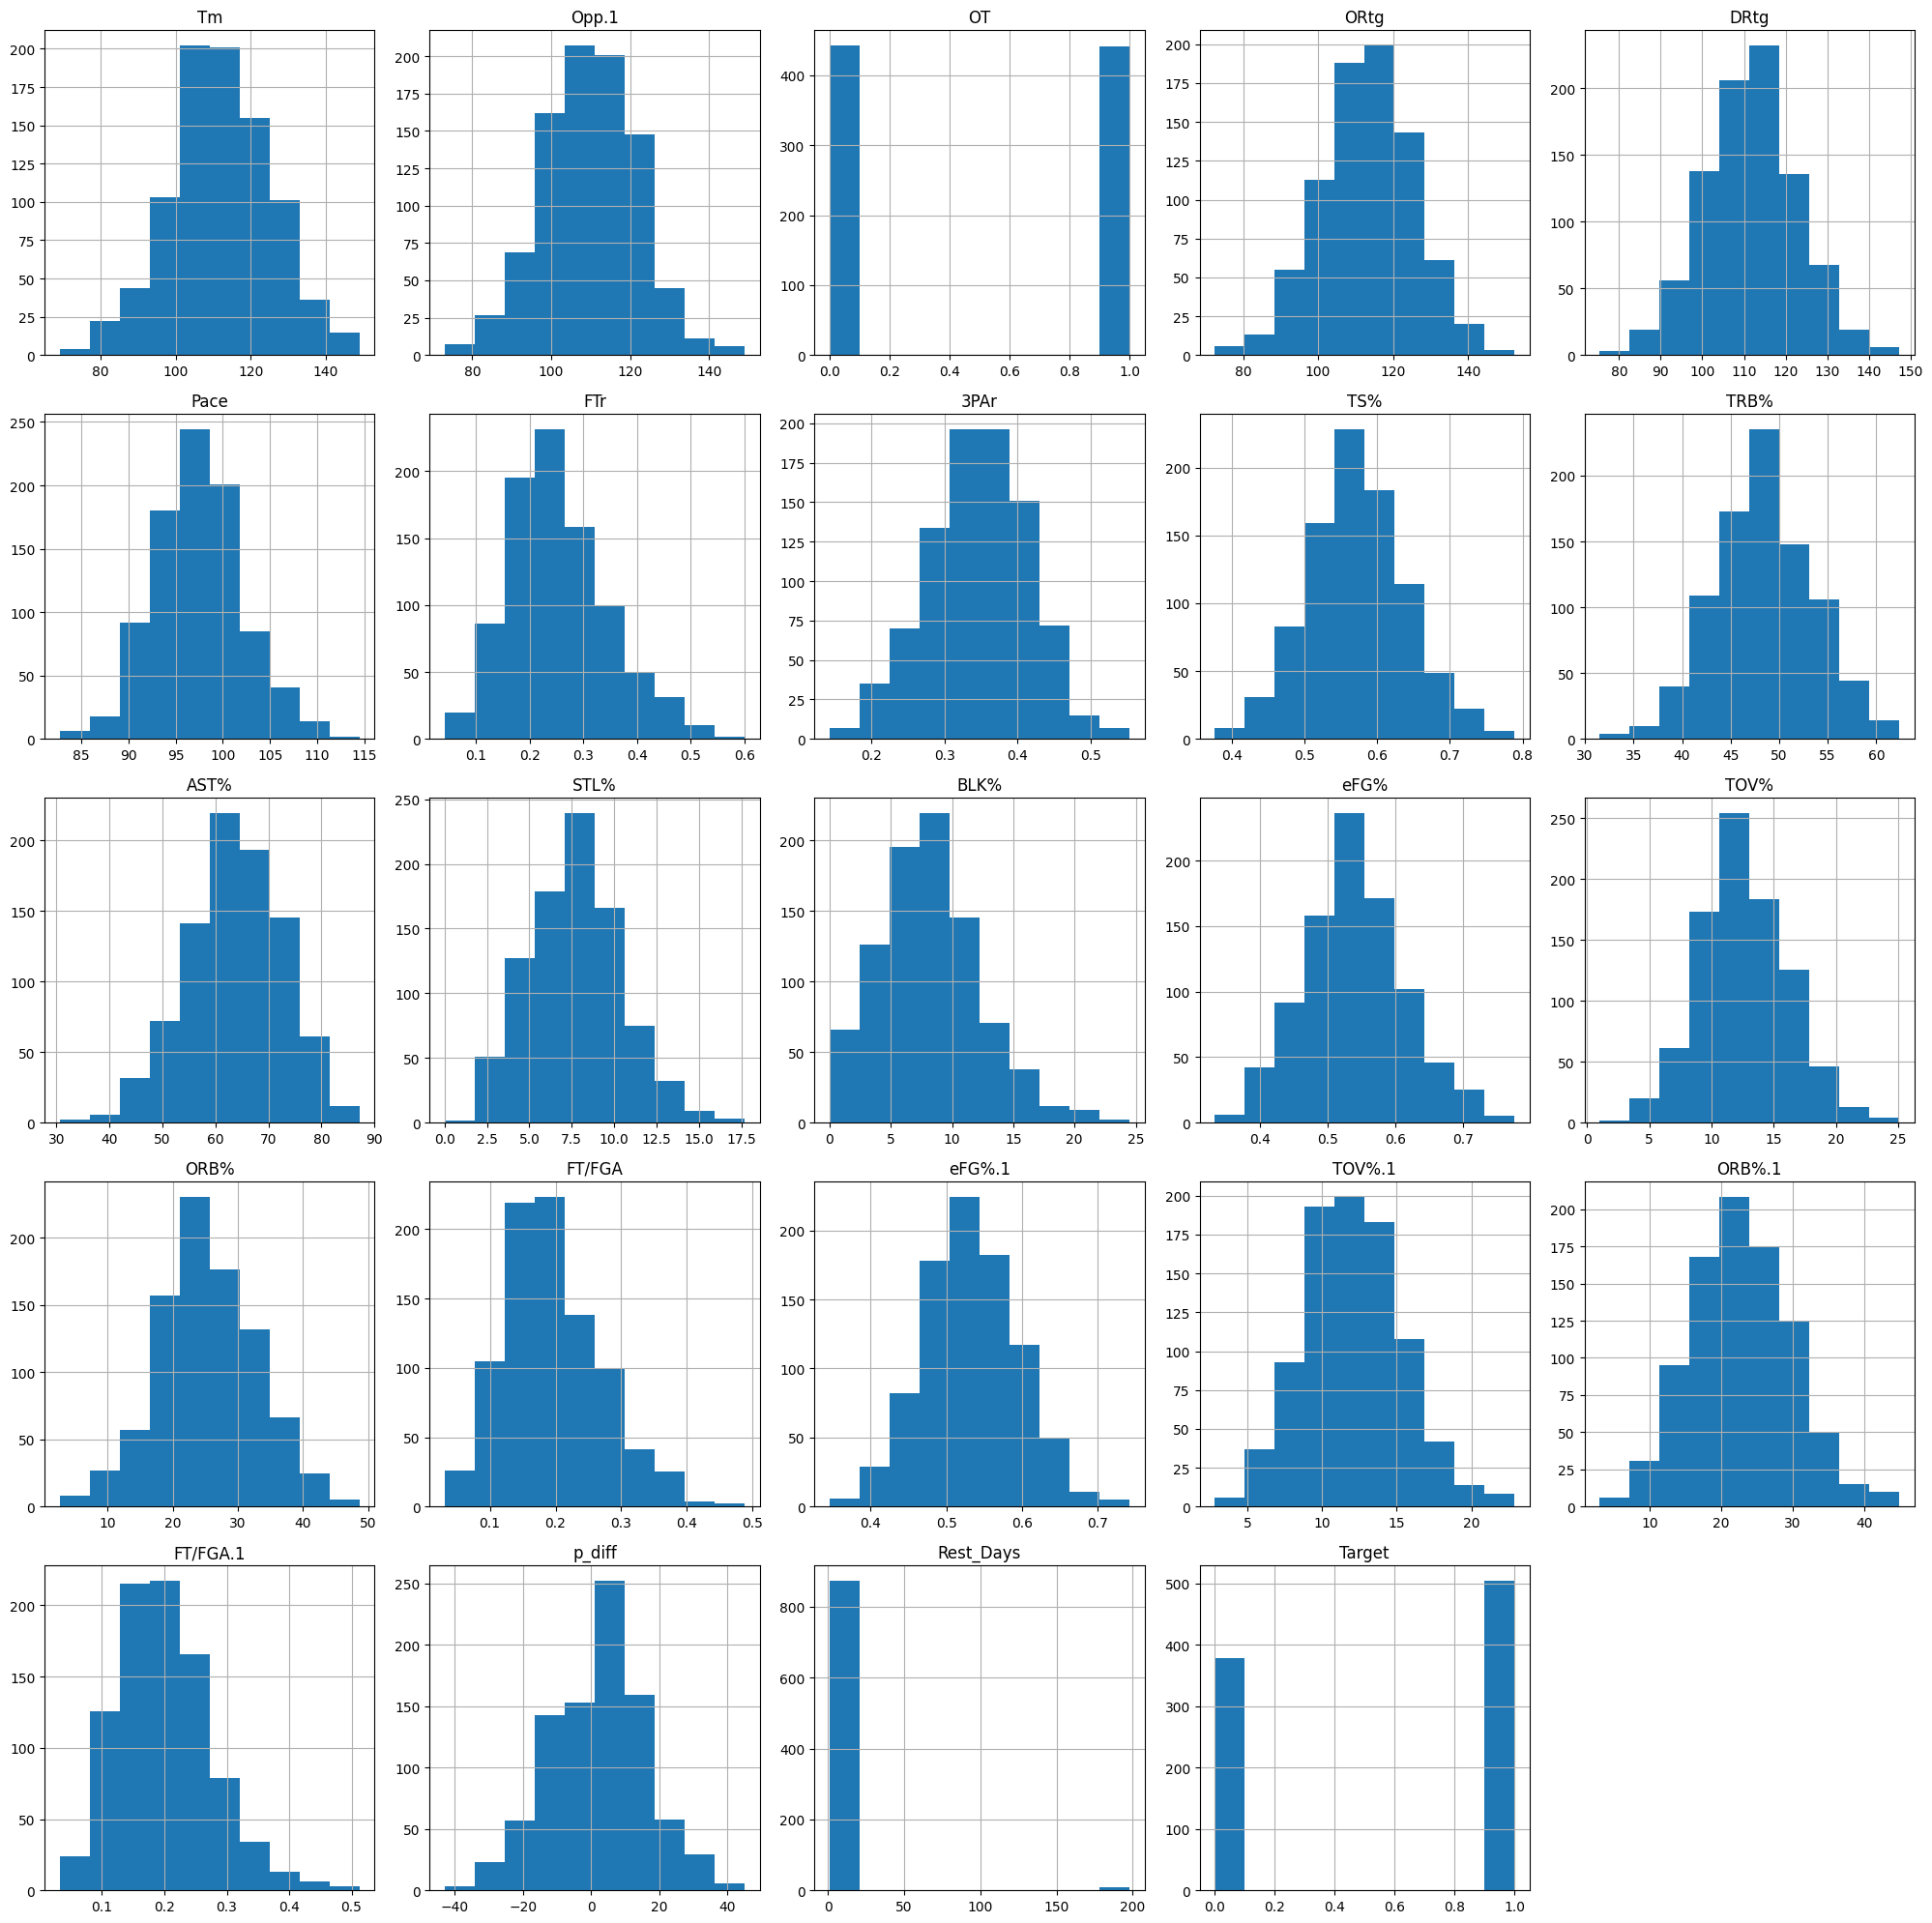

In [793]:
den[cols].hist(figsize=(20,20))
plt.tight_layout()
plt.show()

## Calculate the rolling average

In [794]:
rolling_avg = den.sort_values(['Date'])

# List of numerical columns to create rolling averages for
num_cols = ['Tm','Opp.1','ORtg', 'DRtg', 'Pace', 'FTr', '3PAr', 'TS%', 'TRB%', 'AST%', 'STL%',
            'BLK%', 'eFG%', 'TOV%', 'ORB%', 'FT/FGA', 'eFG%.1', 'TOV%.1',
            'ORB%.1', 'FT/FGA.1', 'p_diff', 'Target']

In [795]:
window_size = 10

In [796]:
# Calculate rolling averages by team
for col in num_cols:
    rolling_avg[f'{col}_rolling{window_size}'] = rolling_avg.groupby('Tm')[col].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).mean()
    )

In [797]:
rolling_avg.head()

,Rk,Gtm,Date,Unnamed: 3,Opp,Rslt,Tm,Opp.1,OT,ORtg,...,eFG%_rolling10,TOV%_rolling10,ORB%_rolling10,FT/FGA_rolling10,eFG%.1_rolling10,TOV%.1_rolling10,ORB%.1_rolling10,FT/FGA.1_rolling10,p_diff_rolling10,Target_rolling10
0,1,1,2014-10-29,NaN,DET,W,89,79,0,91.9,...,0.388,13.2,27.5,0.271,0.405,14.8,17.8,0.131,10.0,1.0
1,2,2,2014-11-01,@,OKC,L,91,102,1,94.2,...,0.481,16.9,23.9,0.175,0.500,13.0,16.7,0.275,-11.0,0.0
2,3,3,2014-11-03,NaN,SAC,L,105,110,0,103.0,...,0.414,12.2,29.4,0.301,0.432,15.0,34.1,0.494,-5.0,0.0
3,4,4,2014-11-05,@,SAC,L,109,131,1,109.6,...,0.506,12.8,18.4,0.317,0.605,11.7,26.5,0.513,-22.0,0.0
4,5,5,2014-11-07,NaN,CLE,L,101,110,0,103.9,...,0.535,12.4,18.2,0.118,0.512,8.4,15.0,0.286,-9.0,0.0


In [798]:
# Plot example of original vs rolling average for one metric
plt.figure(figsize=(15, 6))

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

## Examine correlation with target for original vs rolling features

In [799]:
# Examine correlation with target for original vs rolling features
original_corrs = [rolling_avg[col].corr(rolling_avg['Target']) for col in num_cols]
rolling_corrs = [rolling_avg[f'{col}_rolling{window_size}'].corr(rolling_avg['Target'])
                for col in num_cols]

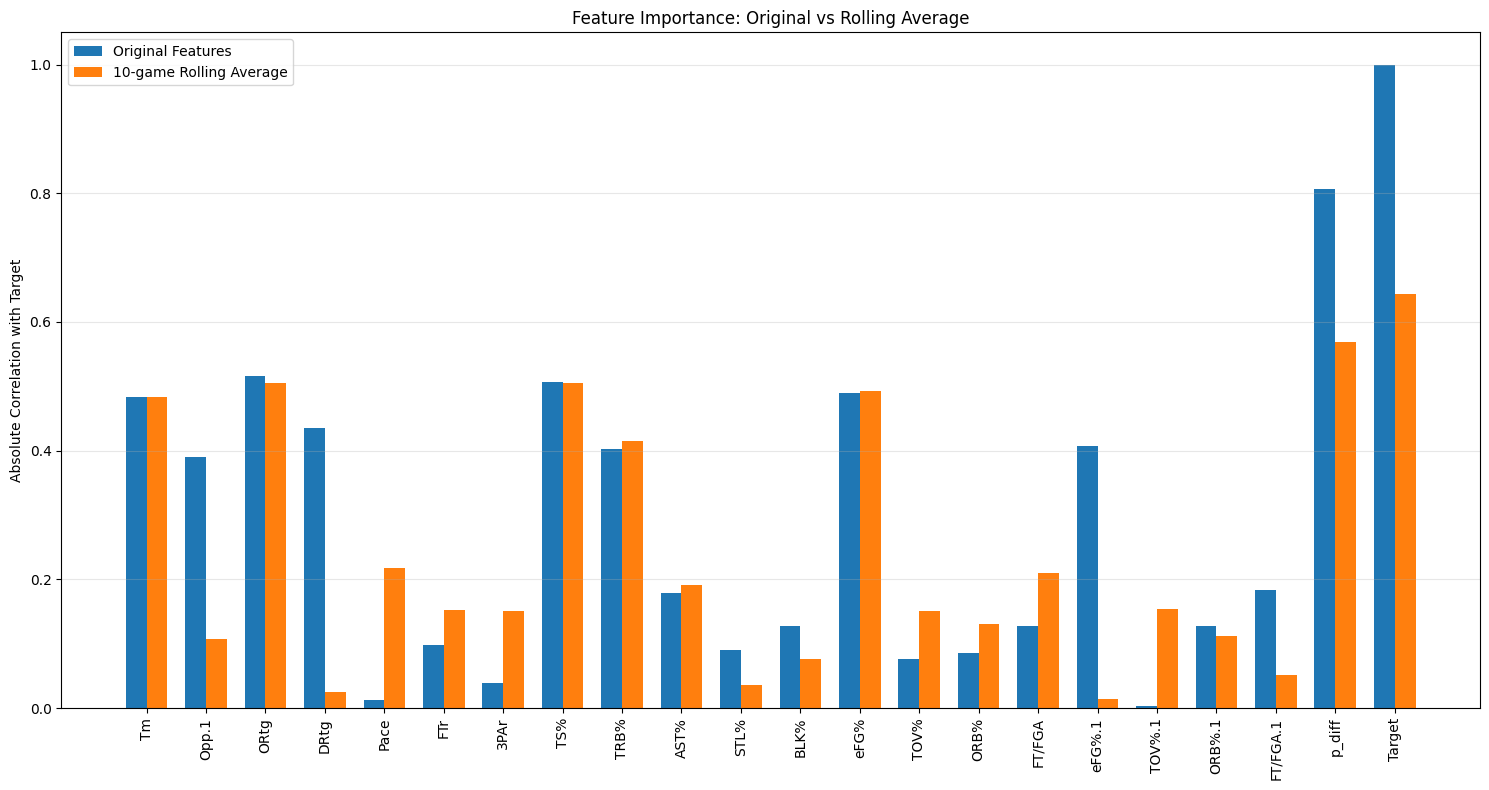

In [800]:
# Plot correlation comparison
plt.figure(figsize=(15, 8))
x = np.arange(len(num_cols))
width = 0.35

plt.bar(x - width/2, [abs(c) for c in original_corrs], width, label='Original Features')
plt.bar(x + width/2, [abs(c) for c in rolling_corrs], width,
        label=f'{window_size}-game Rolling Average')

plt.ylabel('Absolute Correlation with Target')
plt.title('Feature Importance: Original vs Rolling Average')
plt.xticks(x, num_cols, rotation=90)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [801]:
# Print the correlations side by side
comparison = pd.DataFrame({
    'Feature': num_cols,
    'Original_Corr': original_corrs,
    'Rolling_Corr': rolling_corrs,
    'Difference': np.array(rolling_corrs) - np.array(original_corrs)
})
comparison = comparison.sort_values('Difference', ascending=False)
print(comparison)


     Feature  Original_Corr  Rolling_Corr  Difference
1      Opp.1      -0.390540      0.107498    0.498038
3       DRtg      -0.434775      0.024439    0.459214
16    eFG%.1      -0.407187     -0.014330    0.392857
4       Pace       0.013285      0.217652    0.204367
19  FT/FGA.1      -0.183859     -0.051808    0.132050
6       3PAr       0.039571      0.150296    0.110725
15    FT/FGA       0.127487      0.210553    0.083066
5        FTr       0.098060      0.153178    0.055118
14      ORB%       0.085151      0.131003    0.045853
18    ORB%.1      -0.127854     -0.111679    0.016175
9       AST%       0.178321      0.191591    0.013270
12      eFG%       0.490080      0.493172    0.003093
0         Tm       0.483365      0.483365    0.000000
7        TS%       0.506274      0.504551   -0.001722
2       ORtg       0.516011      0.505325   -0.010687
8       TRB%      -0.401936     -0.414720   -0.012784
11      BLK%       0.128098      0.076899   -0.051199
13      TOV%      -0.076077 

<Figure size 2000x1500 with 0 Axes>

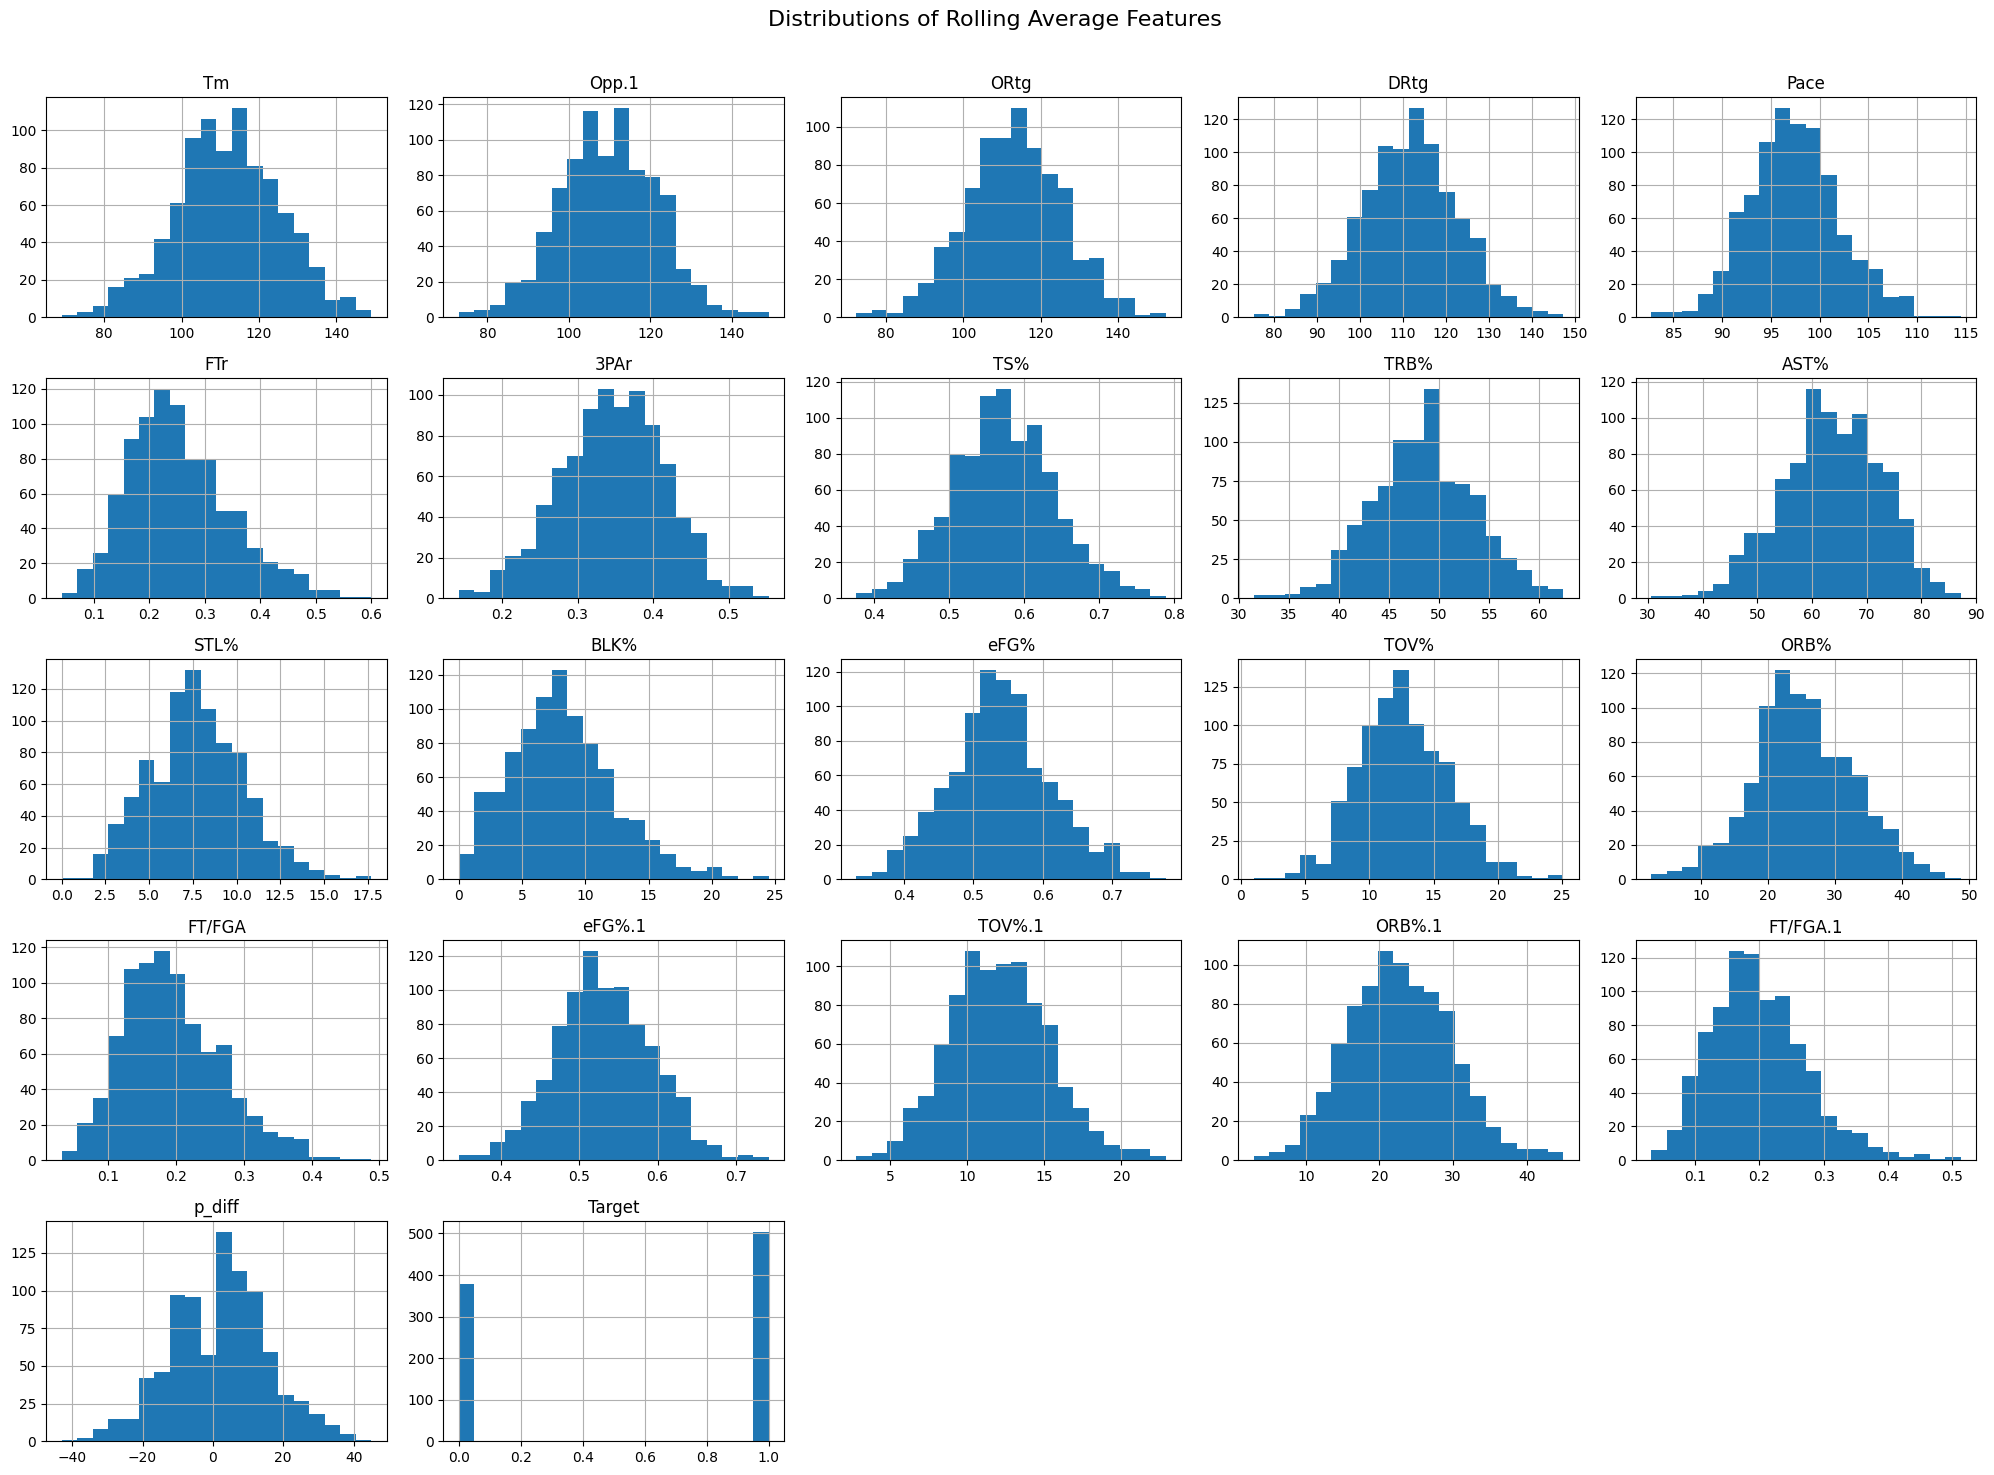

In [802]:
# Identify rolling average columns
num_cols = ['Tm','Opp.1','ORtg', 'DRtg', 'Pace', 'FTr', '3PAr', 'TS%', 'TRB%', 'AST%', 'STL%',
            'BLK%', 'eFG%', 'TOV%', 'ORB%', 'FT/FGA', 'eFG%.1', 'TOV%.1',
            'ORB%.1', 'FT/FGA.1', 'p_diff', 'Target']

# Create histograms for rolling averages
plt.figure(figsize=(20, 15))
rolling_avg[num_cols].hist(figsize=(20, 15), bins=20)
plt.suptitle('Distributions of Rolling Average Features', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


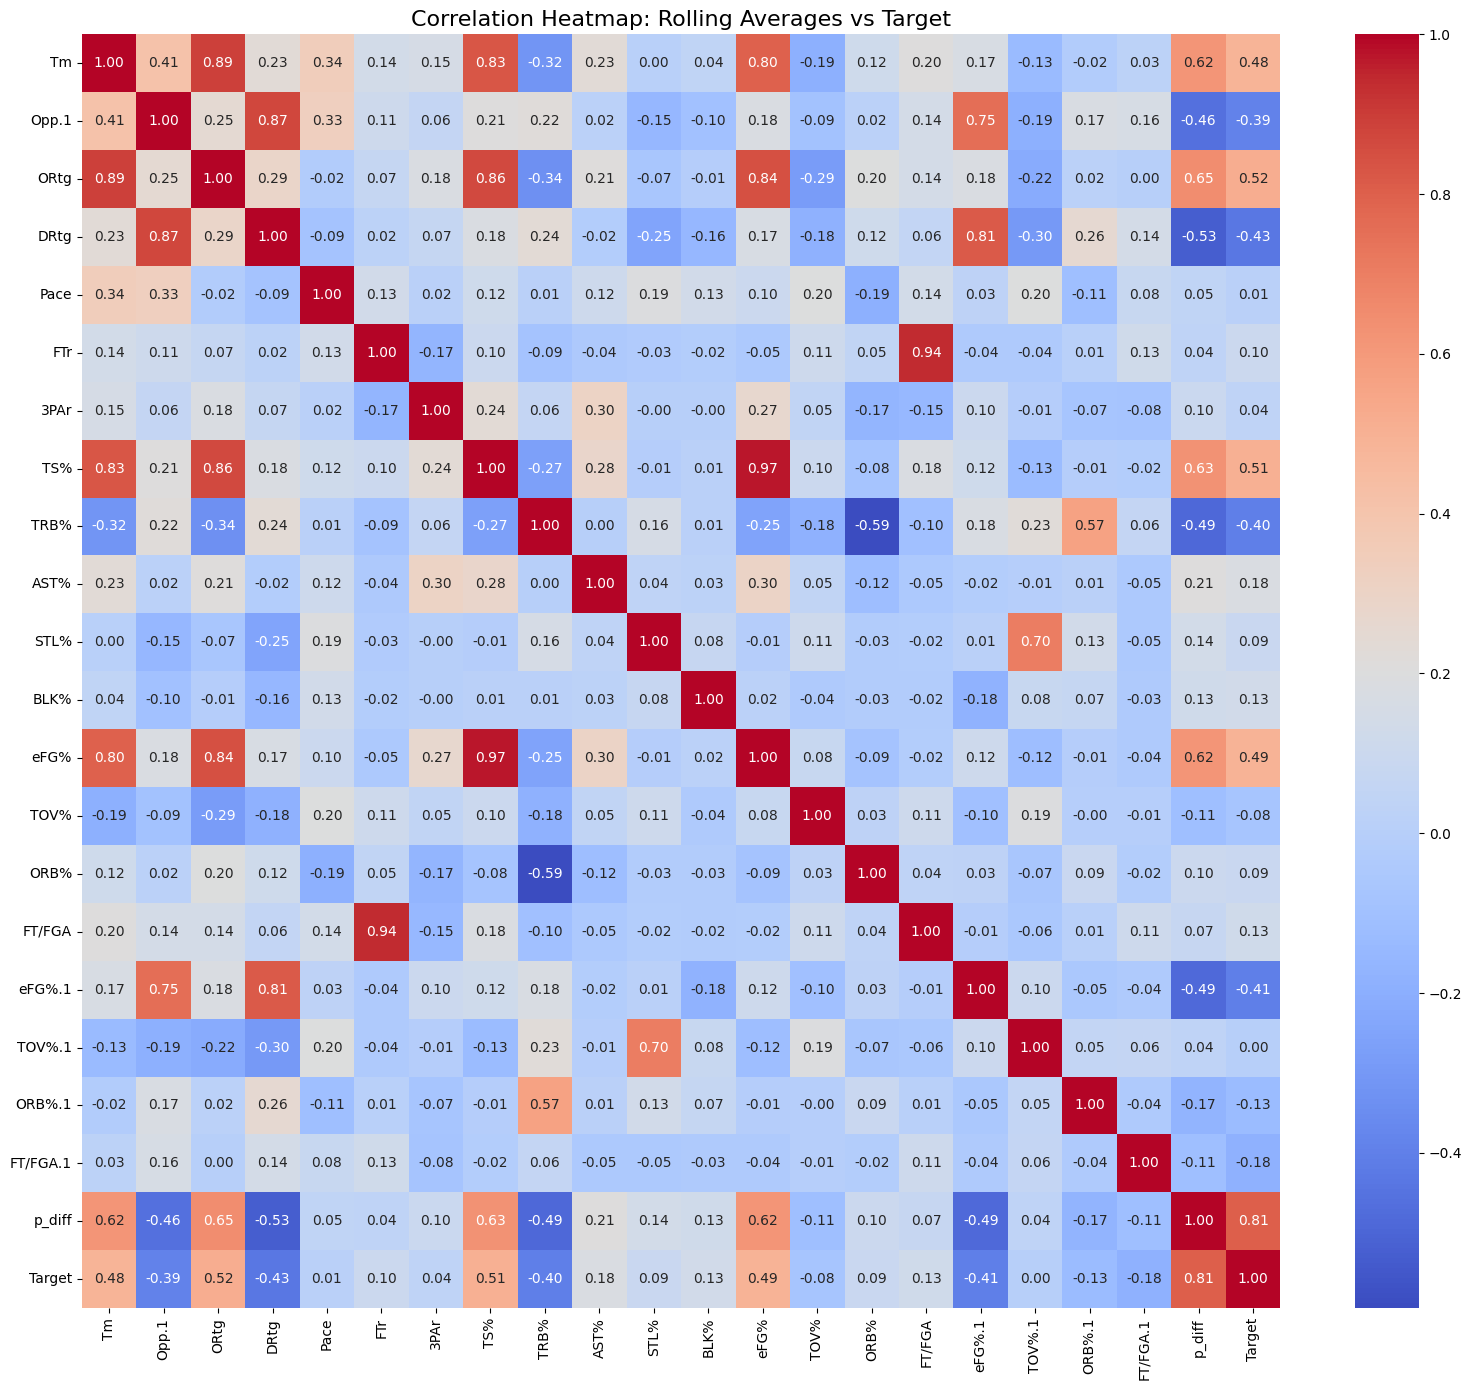

In [803]:
# Create correlation heatmap between rolling features and target
plt.figure(figsize=(16, 14))
analysis_cols = num_cols
sns.heatmap(rolling_avg[analysis_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap: Rolling Averages vs Target', fontsize=16)
plt.tight_layout()
plt.show()

## Scalinig rolling average table

In [804]:
# Get list of rolling columns
rolling_cols = [col for col in rolling_avg.columns if '_rolling10' in col]

# Add other columns you want to keep (non-stat columns)
keep_cols = rolling_cols + ['Target']  # Also keep the Target

# Drop the rest
rolling_avg_clean = rolling_avg[keep_cols]

In [805]:
# Save the columns and index before scaling
cols = rolling_avg_clean.columns
idx = rolling_avg_clean.index

In [806]:
# Drop non-numeric columns first
rolling_avg_clean = rolling_avg_clean.select_dtypes(include=['number'])

In [807]:
rolling_avg_clean.columns

Index(['Tm_rolling10', 'Opp.1_rolling10', 'ORtg_rolling10', 'DRtg_rolling10',
       'Pace_rolling10', 'FTr_rolling10', '3PAr_rolling10', 'TS%_rolling10',
       'TRB%_rolling10', 'AST%_rolling10', 'STL%_rolling10', 'BLK%_rolling10',
       'eFG%_rolling10', 'TOV%_rolling10', 'ORB%_rolling10',
       'FT/FGA_rolling10', 'eFG%.1_rolling10', 'TOV%.1_rolling10',
       'ORB%.1_rolling10', 'FT/FGA.1_rolling10', 'p_diff_rolling10',
       'Target_rolling10', 'Target'],
      dtype='object')

## Scailing

In [808]:
# Save the columns and index before scaling
cols = rolling_avg_clean.columns
idx = rolling_avg_clean.index


In [809]:
scaler = StandardScaler()
rolling_avg_clean = scaler.fit_transform(rolling_avg_clean)

In [810]:
# Convert back to DataFrame
rolling_avg_clean = pd.DataFrame(rolling_avg_clean, columns=cols, index=idx)


## Split the train and test dataset

In [811]:
train_size = int(len(rolling_avg_clean) * 0.8)
X_train = rolling_avg_clean.iloc[:train_size].drop('Target', axis=1)
y_train = rolling_avg_clean.iloc[:train_size]['Target']
X_test = rolling_avg_clean.iloc[train_size:].drop('Target', axis=1)
y_test = rolling_avg_clean.iloc[train_size:]['Target']


## Valid the X & Y dataset


In [812]:
# Check for missing values
print("Missing values in X_train:", X_train.isna().sum().sum())
print("Missing values in X_test:", X_test.isna().sum().sum())

Missing values in X_train: 0
Missing values in X_test: 3


In [813]:
# See which columns have missing values
missing_cols = X_train.columns[X_train.isna().any()].tolist()
print("Columns with missing values:", missing_cols)

# Impute missing values using the mean of each column
# Important: Calculate means from training data only
column_means = X_train.mean()

Columns with missing values: []


In [814]:
# Apply imputation to both train and test sets
X_train_clean = X_train.fillna(column_means)
X_test_clean = X_test.fillna(column_means)

In [815]:
# Verify no more missing values
print("Missing values after imputation (train):", X_train_clean.isna().sum().sum())
print("Missing values after imputation (test):", X_test_clean.isna().sum().sum())

Missing values after imputation (train): 0
Missing values after imputation (test): 0


In [816]:
print("Target variable values:", y_train.unique())
print("Target variable type:", y_train.dtype)

# Make sure target is numeric and binary (for logistic regression)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

Target variable values: [ 0.86717018 -1.15317618]
Target variable type: float64


In [817]:
# Check for constant features
constant_features = [col for col in X_train.columns if X_train[col].nunique() <= 1]
if constant_features:
    print("Dropping constant features:", constant_features)
    X_train = X_train.drop(columns=constant_features)
    X_test = X_test.drop(columns=constant_features)

# Check for duplicated columns
duplicated_cols = X_train.T.duplicated()
if duplicated_cols.any():
    print(f"Found {duplicated_cols.sum()} duplicated columns")
    X_train = X_train.loc[:, ~duplicated_cols]
    X_test = X_test.loc[:, ~duplicated_cols]

# Logistic Regression

## Grid search

In [818]:
param_grid = [
    # L1 penalty (saga supports l1 for multinomial/binary, liblinear for binary)
    {
        'penalty': ['l1'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['saga', 'liblinear'],
        'max_iter': [1000],
    },
    # L2 penalty (supported by most solvers)
    {
        'penalty': ['l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'saga', 'liblinear', 'newton-cg'],
        'max_iter': [1000],
    },
    # ElasticNet penalty (only saga supports elasticnet)
    {
        'penalty': ['elasticnet'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['saga'],
        'l1_ratio': [0.1, 0.5, 0.9],
        'max_iter': [1000],
    }
]


In [819]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)


In [820]:
tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=tscv,  # Use simple CV first, not tscv
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    error_score='raise'  # This will show detailed error
)



In [821]:
grid_search.fit(X_train_clean, y_train)


Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             error_score='raise',
             estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'max_iter': [1000], 'penalty': ['l1'],
                          'solver': ['saga', 'liblinear']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'max_iter': [1000], 'penalty': ['l2'],
                          'solver': ['lbfgs', 'saga', 'liblinear',
                                     'newton-cg']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'l1_ratio': [0.1, 0.5, 0.9], 'max_iter': [1000],
                          'penalty': ['elasticnet'], 'solver': ['saga']}],
             scoring='accuracy', verbose=1)

In [822]:
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Best parameters: {'C': 100, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.741880341880342


In [823]:
best_model = grid_search.best_estimator_

## Make prediction & Result metrics

In [824]:
# Make predictions
# Evaluate on test set
y_pred = best_model.predict(X_test_clean)


# Calculate metrics
print("Test set accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Test set accuracy: 0.768361581920904

Classification Report:
              precision    recall  f1-score   support

          -1       0.68      0.65      0.67        63
           0       0.81      0.83      0.82       114

    accuracy                           0.77       177
   macro avg       0.75      0.74      0.74       177
weighted avg       0.77      0.77      0.77       177


Confusion Matrix:
[[41 22]
 [19 95]]


In [825]:
# Check distribution of actual classes in test set
print("Unique values in y_test:", y_test.unique())
print("Count of each class in y_test:", y_test.value_counts())

# Make sure predict_proba is working correctly
try:
    y_pred_proba = best_model.predict_proba(X_test_clean)
    print("Shape of probability array:", y_pred_proba.shape)
    print("First few probability predictions:", y_pred_proba[:5])

    # Try ROC AUC with explicit handling of classes
    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    print("ROC AUC Score:", auc)
except Exception as e:
    print(f"Error details: {e}")

    # Alternative: Try average precision score instead
    from sklearn.metrics import average_precision_score
    try:
        ap = average_precision_score(y_test, y_pred_proba[:, 1])
        print("Average Precision Score:", ap)
    except Exception as e:
        print(f"Average Precision Score error: {e}")

Unique values in y_test: [ 0 -1]
Count of each class in y_test: Target
 0    114
-1     63
Name: count, dtype: int64
Shape of probability array: (177, 2)
First few probability predictions: [[0.21867195 0.78132805]
 [0.46455277 0.53544723]
 [0.81719517 0.18280483]
 [0.21989451 0.78010549]
 [0.06695839 0.93304161]]
ROC AUC Score: 0.821776663881927


In [826]:
# cv_score - cross-validation score of the best model
cv_score = grid_search.best_score_

# gs_score - same as cv_score in this context
gs_score = grid_search.best_score_

# train_score - performance on training data
train_score = best_model.score(X_train_clean, y_train)

# test_score - performance on test data (you already have this)
test_score = accuracy_score(y_test, y_pred)

print(f"Model: Logistic Regression")
print(f"cv_score: {cv_score:.4f}")
print(f"gs_score: {gs_score:.4f}")
print(f"train_score: {train_score:.4f}")
print(f"test_score: {test_score:.4f}")

Model: Logistic Regression
cv_score: 0.7419
gs_score: 0.7419
train_score: 0.7890
test_score: 0.7684


In [827]:
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

In [828]:
report = classification_report(y_test, y_pred, output_dict=True)
support = sum([v['support'] for k, v in report.items() if k.isdigit()])

In [829]:
report = classification_report(y_test, y_pred, output_dict=True)
support = sum([v['support'] for k, v in report.items() if k.isdigit()])

In [830]:
if hasattr(grid_search.best_estimator_, "predict_proba"):
    y_proba = grid_search.best_estimator_.predict_proba(X_test_clean)
    if len(grid_search.best_estimator_.classes_) == 2:
        # Binary case
        pos_class_index = list(grid_search.best_estimator_.classes_).index(0)  # or your "positive" class
        y_proba_pos = y_proba[:, pos_class_index]
        try:
            roc = roc_auc_score(y_test, y_proba_pos)
        except Exception:
            roc = None
    else:
        # Multiclass case
        try:
            roc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
        except Exception:
            roc = None
else:
    roc = None

In [831]:
# Initialize an empty list to store results
results = []

In [832]:
results.append({
    "model": "Logistic Regression",
    "cv_score": grid_search.best_score_,
    "gs_score": grid_search.best_score_,
    "train_score": grid_search.best_estimator_.score(X_train_clean, y_train),
    "test_score": accuracy_score(y_test, y_pred),
    "f1": f1,
    "precision": precision,
    "recall": recall,
    "support": support,
    "roc_auc": roc
})

In [833]:
# Convert the list of dicts to a DataFrame
result_metrics = pd.DataFrame(results)

# Set 'model' as the index
result_metrics.set_index('model', inplace=True)

# Print the DataFrame
print(result_metrics)

                     cv_score  gs_score  train_score  test_score        f1  \
model                                                                        
Logistic Regression   0.74188   0.74188     0.788952    0.768362  0.767041   

                     precision    recall  support   roc_auc  
model                                                        
Logistic Regression   0.766181  0.768362    114.0  0.821777  


# KNN

In [834]:
knn = KNeighborsClassifier(n_neighbors=5)

In [835]:
param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11]}
knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=tscv)
knn_grid.fit(X_train_clean, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11]})

In [836]:
y_pred_knn = knn_grid.predict(X_test_clean)

In [837]:
best_knn = knn_grid.best_estimator_

In [838]:
f1 = f1_score(y_test, y_pred_knn, average='weighted')
precision = precision_score(y_test, y_pred_knn, average='weighted')
recall = recall_score(y_test, y_pred_knn, average='weighted')

In [839]:
report = classification_report(y_test, y_pred_knn, output_dict=True)
support = sum([v['support'] for k, v in report.items() if k.isdigit()])

In [840]:
if hasattr(knn_grid.best_estimator_, "predict_proba"):
    y_proba = knn_grid.best_estimator_.predict_proba(X_test_clean)
    if len(knn_grid.best_estimator_.classes_) == 2:
        # Binary case
        pos_class_index = list(knn_grid.best_estimator_.classes_).index(0)  # or your "positive" class
        y_proba_pos = y_proba[:, pos_class_index]
        try:
            roc = roc_auc_score(y_test, y_proba_pos)
        except Exception:
            roc = None
    else:
        # Multiclass case
        try:
            roc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
        except Exception:
            roc = None
else:
    roc = None

In [841]:
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Test Accuracy: 0.768361581920904
Classification Report:
               precision    recall  f1-score   support

          -1       0.68      0.65      0.67        63
           0       0.81      0.83      0.82       114

    accuracy                           0.77       177
   macro avg       0.75      0.74      0.74       177
weighted avg       0.77      0.77      0.77       177

Confusion Matrix:
 [[41 22]
 [19 95]]


In [842]:
results.append({
    "model": "KNN",
    "cv_score": knn_grid.best_score_,
    "gs_score": knn_grid.best_score_,
    "train_score": knn_grid.best_estimator_.score(X_train_clean, y_train),
    "test_score": accuracy_score(y_test, y_pred_knn),
    "f1": f1,
    "precision": precision,
    "recall": recall,
    "support": support,
    "roc_auc": roc
})

In [843]:
result_metrics = pd.DataFrame(results)
result_metrics.set_index('model', inplace=True)
print(result_metrics)


                     cv_score  gs_score  train_score  test_score        f1  \
model                                                                        
Logistic Regression  0.741880  0.741880     0.788952    0.768362  0.767041   
KNN                  0.699145  0.699145     0.788952    0.728814  0.716136   

                     precision    recall  support   roc_auc  
model                                                        
Logistic Regression   0.766181  0.768362    114.0  0.821777  
KNN                   0.720339  0.728814    114.0  0.752158  


# Rainforest

In [844]:
param_grid_rf = {
    'n_estimators': [100, 200],        # Number of trees in the forest
    'max_depth': [None, 5, 10, 15, 20],       # Depth of each tree
    'min_samples_split': [2, 5],       # Min samples to split a node
    'min_samples_leaf': [1, 2]         # Min samples at a leaf node
}

In [845]:
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=tscv,
    n_jobs=-1
)


In [846]:
rf_grid.fit(X_train_clean, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 15, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]})

In [847]:
y_pred_rf = rf_grid.predict(X_test_clean)

In [848]:
best_rf = rf_grid.best_estimator_

In [849]:
f1 = f1_score(y_test, y_pred_rf, average='weighted')
precision = precision_score(y_test, y_pred_rf, average='weighted')
recall = recall_score(y_test, y_pred_rf, average='weighted')

In [850]:
# Support (number of true samples in y_test)
report = classification_report(y_test, y_pred_rf, output_dict=True)
support = sum([v['support'] for k, v in report.items() if k.isdigit()])

In [851]:
if hasattr(rf_grid.best_estimator_, "predict_proba"):
    y_proba = rf_grid.best_estimator_.predict_proba(X_test_clean)
    if len(rf_grid.best_estimator_.classes_) == 2:
        # Binary case
        pos_class_index = list(rf_grid.best_estimator_.classes_).index(0)  # or your "positive" class
        y_proba_pos = y_proba[:, pos_class_index]
        try:
            roc = roc_auc_score(y_test, y_proba_pos)
        except Exception:
            roc = None
    else:
        # Multiclass case
        try:
            roc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
        except Exception:
            roc = None
else:
    roc = None

In [852]:
results.append({
    "model": "Random Forest",
    "cv_score": rf_grid.best_score_,
    "gs_score": rf_grid.best_score_,
    "train_score": rf_grid.best_estimator_.score(X_train_clean, y_train),
    "test_score": accuracy_score(y_test, y_pred_rf),
    "f1": f1,
    "precision": precision,
    "recall": recall,
    "support": support,
    "roc_auc": roc
})

In [853]:
result_metrics = pd.DataFrame(results)
result_metrics.set_index('model', inplace=True)
print(result_metrics)

                     cv_score  gs_score  train_score  test_score        f1  \
model                                                                        
Logistic Regression  0.741880  0.741880     0.788952    0.768362  0.767041   
KNN                  0.699145  0.699145     0.788952    0.728814  0.716136   
Random Forest        0.748718  0.748718     0.990085    0.774011  0.771259   

                     precision    recall  support   roc_auc  
model                                                        
Logistic Regression   0.766181  0.768362    114.0  0.821777  
KNN                   0.720339  0.728814    114.0  0.752158  
Random Forest         0.770398  0.774011    114.0  0.815929  


# ANN

In [854]:
param_grid_ann = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],  # L2 penalty (regularization)
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [200]  # You can increase if convergence warnings occur
}

In [855]:
ann_grid = GridSearchCV(
    MLPClassifier(random_state=42),
    param_grid_ann,
    cv=tscv,
    n_jobs=-1
)

In [856]:
ann_grid.fit(X_train_clean, y_train)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=MLPClassifier(random_state=42), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0001, 0.001],
                         'hidden_layer_sizes': [(50,), (100,), (50, 50)],
                         'learning_rate': ['constant', 'adaptive'],
                         'max_iter': [200], 'solver': ['adam']})

In [857]:
y_pred_ann = ann_grid.predict(X_test_clean)

In [858]:
# Calculate metrics
f1 = f1_score(y_test, y_pred_ann, average='weighted')
precision = precision_score(y_test, y_pred_ann, average='weighted')
recall = recall_score(y_test, y_pred_ann, average='weighted')

In [859]:
# Support (number of true samples in y_test)
report = classification_report(y_test, y_pred_ann, output_dict=True)
support = sum([v['support'] for k, v in report.items() if k.isdigit()])

In [860]:
if hasattr(ann_grid.best_estimator_, "predict_proba"):
    y_proba = ann_grid.best_estimator_.predict_proba(X_test_clean)
    if len(ann_grid.best_estimator_.classes_) == 2:
        # Binary case
        pos_class_index = list(ann_grid.best_estimator_.classes_).index(0)  # or your "positive" class
        y_proba_pos = y_proba[:, pos_class_index]
        try:
            roc = roc_auc_score(y_test, y_proba_pos)
        except Exception:
            roc = None
    else:
        # Multiclass case
        try:
            roc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
        except Exception:
            roc = None
else:
    roc = None


In [861]:
results.append({
    "model": "ANN",
    "cv_score": ann_grid.best_score_,
    "gs_score": ann_grid.best_score_,
    "train_score": ann_grid.best_estimator_.score(X_train_clean, y_train),
    "test_score": accuracy_score(y_test, y_pred_ann),
    "f1": f1,
    "precision": precision,
    "recall": recall,
    "support": support,
    "roc_auc": roc
})

In [862]:
result_metrics = pd.DataFrame(results)
result_metrics.set_index('model', inplace=True)
print(result_metrics)

                     cv_score  gs_score  train_score  test_score        f1  \
model                                                                        
Logistic Regression  0.741880  0.741880     0.788952    0.768362  0.767041   
KNN                  0.699145  0.699145     0.788952    0.728814  0.716136   
Random Forest        0.748718  0.748718     0.990085    0.774011  0.771259   
ANN                  0.743590  0.743590     0.893768    0.751412  0.754850   

                     precision    recall  support   roc_auc  
model                                                        
Logistic Regression   0.766181  0.768362    114.0  0.821777  
KNN                   0.720339  0.728814    114.0  0.752158  
Random Forest         0.770398  0.774011    114.0  0.815929  
ANN                   0.763074  0.751412    114.0  0.811752  


In [863]:
print("Unique classes in y_test:", set(y_test))
print("Shape of y_proba:", y_proba.shape)
print("Classes in ann_grid.best_estimator_:", ann_grid.best_estimator_.classes_)

Unique classes in y_test: {0, -1}
Shape of y_proba: (177, 2)
Classes in ann_grid.best_estimator_: [-1  0]


# Naïve Bayes

In [864]:
nb_clf = GaussianNB()
nb_clf.fit(X_train_clean, y_train)

GaussianNB()

In [865]:
y_pred_nb = nb_clf.predict(X_test_clean)

In [866]:
cv_scores = cross_val_score(nb_clf, X_train, y_train, cv=tscv)
cv_score_nb = cv_scores.mean()


In [867]:
f1 = f1_score(y_test, y_pred_nb, average='weighted')
precision = precision_score(y_test, y_pred_nb, average='weighted')
recall = recall_score(y_test, y_pred_nb, average='weighted')

In [868]:
# Support (number of true samples in y_test)
report = classification_report(y_test, y_pred_nb, output_dict=True)
support = sum([v['support'] for k, v in report.items() if k.isdigit()])

In [869]:
if hasattr(nb_clf, "predict_proba"):
    y_proba = nb_clf.predict_proba(X_test_clean)
    try:
        roc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
    except:
        roc = None
else:
    roc = None

In [870]:


results.append({
    "model": "Naive Bayes",
    "cv_score": cv_score_nb,  # Or your cross-validation score if available
    "gs_score": None,  # Or your grid search score if available
    "train_score": nb_clf.score(X_train_clean, y_train),
    "test_score": accuracy_score(y_test, y_pred_nb),
    "f1": f1,
    "precision": precision,
    "recall": recall,
    "support": support,
    "roc_auc": roc
})

In [871]:
result_metrics = pd.DataFrame(results)
result_metrics.set_index('model', inplace=True)
print(result_metrics)

                     cv_score  gs_score  train_score  test_score        f1  \
model                                                                        
Logistic Regression  0.741880  0.741880     0.788952    0.768362  0.767041   
KNN                  0.699145  0.699145     0.788952    0.728814  0.716136   
Random Forest        0.748718  0.748718     0.990085    0.774011  0.771259   
ANN                  0.743590  0.743590     0.893768    0.751412  0.754850   
Naive Bayes          0.743590       NaN     0.757790    0.768362  0.759860   

                     precision    recall  support   roc_auc  
model                                                        
Logistic Regression   0.766181  0.768362    114.0  0.821777  
KNN                   0.720339  0.728814    114.0  0.752158  
Random Forest         0.770398  0.774011    114.0  0.815929  
ANN                   0.763074  0.751412    114.0  0.811752  
Naive Bayes           0.763804  0.768362    114.0       NaN  


#Support Vector Classifier (SVC)

In [872]:
param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # Only used for 'rbf'
}

svc_grid = GridSearchCV(
    SVC(random_state=42),
    param_grid_svc,
    cv=tscv,
    n_jobs=-1
)

In [873]:
svc_grid.fit(X_train_clean, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']})

In [874]:
y_pred_svc = svc_grid.predict(X_test_clean)

In [875]:
# Calculate metrics
f1 = f1_score(y_test, y_pred_svc, average='weighted')
precision = precision_score(y_test, y_pred_svc, average='weighted')
recall = recall_score(y_test, y_pred_svc, average='weighted')

In [876]:
# Support (number of true samples in y_test)
report = classification_report(y_test, y_pred_svc, output_dict=True)
support = sum([v['support'] for k, v in report.items() if k.isdigit()])

In [877]:
print("y_test_bin shape:", y_test.shape)
print("y_proba_pos shape:", y_proba.shape)

y_test_bin shape: (177,)
y_proba_pos shape: (177, 2)


In [878]:
print("Unique values in y_test:", np.unique(y_test))

Unique values in y_test: [-1  0]


In [879]:
pos_class_index = list(svc_grid.best_estimator_.classes_).index(0)
y_proba_pos = y_proba[:, pos_class_index]  # This should be shape (177,)
print("y_proba_pos shape:", y_proba_pos.shape)

y_proba_pos shape: (177,)


In [880]:
roc = roc_auc_score(y_test, y_proba_pos)

In [881]:
roc

np.float64(0.8475355054302424)

In [882]:
results.append({
    "model": "SVC",
    "cv_score": svc_grid.best_score_,
    "gs_score": svc_grid.best_score_,
    "train_score": svc_grid.best_estimator_.score(X_train_clean, y_train),
    "test_score": accuracy_score(y_test, y_pred_svc),
    "f1": f1,
    "precision": precision,
    "recall": recall,
    "support": support,
    "roc_auc": roc
})

In [883]:
result_metrics = pd.DataFrame(results)
result_metrics.set_index('model', inplace=True)
print(result_metrics)

                     cv_score  gs_score  train_score  test_score        f1  \
model                                                                        
Logistic Regression  0.741880  0.741880     0.788952    0.768362  0.767041   
KNN                  0.699145  0.699145     0.788952    0.728814  0.716136   
Random Forest        0.748718  0.748718     0.990085    0.774011  0.771259   
ANN                  0.743590  0.743590     0.893768    0.751412  0.754850   
Naive Bayes          0.743590       NaN     0.757790    0.768362  0.759860   
SVC                  0.721368  0.721368     0.786119    0.774011  0.772255   

                     precision    recall  support   roc_auc  
model                                                        
Logistic Regression   0.766181  0.768362    114.0  0.821777  
KNN                   0.720339  0.728814    114.0  0.752158  
Random Forest         0.770398  0.774011    114.0  0.815929  
ANN                   0.763074  0.751412    114.0  0.811752  
Nai

In [884]:
result_metrics

,cv_score,gs_score,train_score,test_score,f1,precision,recall,support,roc_auc
model,,,,,,,,,
Logistic Regression,0.741880,0.741880,0.788952,0.768362,0.767041,0.766181,0.768362,114.0,0.821777
KNN,0.699145,0.699145,0.788952,0.728814,0.716136,0.720339,0.728814,114.0,0.752158
Random Forest,0.748718,0.748718,0.990085,0.774011,0.771259,0.770398,0.774011,114.0,0.815929
ANN,0.743590,0.743590,0.893768,0.751412,0.754850,0.763074,0.751412,114.0,0.811752
Naive Bayes,0.743590,NaN,0.757790,0.768362,0.759860,0.763804,0.768362,114.0,NaN
SVC,0.721368,0.721368,0.786119,0.774011,0.772255,0.771330,0.774011,114.0,0.847536
